# ANÁLISIS EXPLORATORIO BIVARIADO


In [1]:
# Importación de librerías
#Hola
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats
from scipy.stats import anderson, levene, chi2_contingency

# Carga del dataset y construcción del dataframe de trabajo
datos = pd.read_csv(r"/Users/pctm/Downloads/data_payments.csv")

df = datos.rename(columns={
    'KEY': 'clave',
    'FREQ':'frecuencia',
    'REF_AREA': 'pais_origen',
    'COUNT_AREA': 'pais_destino',
    'TYP_TRNSCTN': 'tipo_trx',
    'RL_TRNSCTN': 'tipo_psp',
    'FRD_TYP': 'tipo_fraude',
    'UNIT_MEASURE': 'unidad',   
    'TIME_PERIOD': 'anio',
    'OBS_VALUE': 'monto',
    'OBS_STATUS': 'tipo_monto',
    'DECIMALS':'decimales',
    'TITLE': 'descripcion',
    'UNIT_MULT':'multiplicador_unidad'
})

datos2 = df[[  
    'clave','frecuencia','pais_origen','pais_destino',
    'tipo_trx','tipo_psp','tipo_fraude',  'unidad',
    'anio','monto','tipo_monto','decimales',
    'descripcion','multiplicador_unidad'
]].copy()
datos2['anio'] = datos2['anio'].astype(str).str[:4]
datos2['tipo_fraude'] = (
    datos2['tipo_fraude']
    .str.replace('_Z', 'sin fraude', regex=False)
    .str.replace('F', 'con fraude', regex=False)
)
datos2.head()

,clave,frecuencia,pais_origen,pais_destino,tipo_trx,tipo_psp,tipo_fraude,unidad,anio,monto,tipo_monto,decimales,descripcion,multiplicador_unidad
0,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,sin fraude,PN,2014,0.242,A,3,"Total payment transactions, incl. cash withdra...",6
1,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,sin fraude,PN,2015,0.268,A,3,"Total payment transactions, incl. cash withdra...",6
2,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,sin fraude,PN,2016,0.689,A,3,"Total payment transactions, incl. cash withdra...",6
3,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,sin fraude,PN,2017,0.632,A,3,"Total payment transactions, incl. cash withdra...",6
4,PAY.A.AT.BG.TOTL.1._Z.N.PN,A,AT,BG,TOTL,1,sin fraude,PN,2018,0.615,A,3,"Total payment transactions, incl. cash withdra...",6



## Análisis de la variable de respuesta frente a las variables numéricas

Realizaremos la comparación de la variable “tipo_fraude” correspondiente al tipo de fraude con la única variable númerica del dataset, la cual es “monto” correspondiente al valor de la transacción. En este caso, la variable de respuesta solo tiene dos opciones: “sin fraude” y “con fraude”, por tanto, se tomarán estos dos grupos y se analizará el valor de la transacción mediante el grafico de caja y bigotes bivariado para estas variables y se compararán las medias de estos dos grupos independientes, para ello se verificarán los supuestos de normalidad e igualdad de varianza para elegir la prueba correspondiente para al caso.

### Gráfico de caja y bigotes multiple

/var/folders/x3/pv5pxgpn24d3dg_tsmkjptgc0000gn/T/ipykernel_9285/2461061043.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(grupos, labels=etiquetas, patch_artist=True,


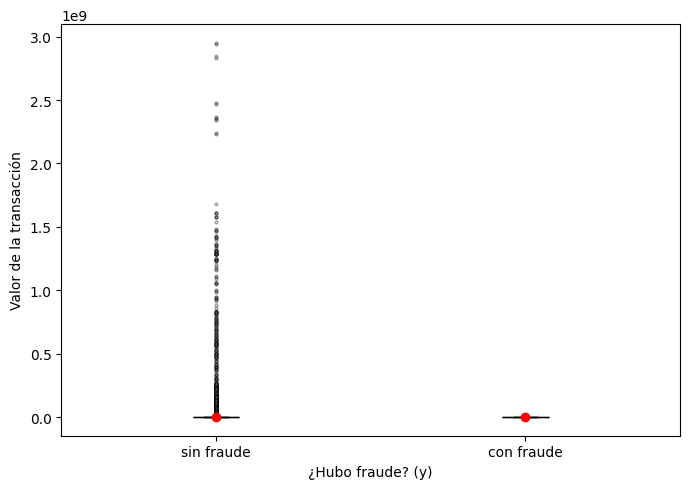

In [2]:
fig, ax = plt.subplots(figsize=(7, 5))

grupos = [datos2[datos2['tipo_fraude'] == g]['monto'].dropna() for g in datos2['tipo_fraude'].unique()]
etiquetas = list(datos2['tipo_fraude'].unique())

bp = ax.boxplot(grupos, labels=etiquetas, patch_artist=True,
                boxprops=dict(facecolor='#1E90FF', alpha=0.6, color='black'),
                medianprops=dict(color='black'),
                flierprops=dict(markerfacecolor='gray', marker='o', markersize=2, alpha=0.3))
for i, g in enumerate(grupos, start=1):
    ax.plot(i, g.mean(), marker='o', color='red', markersize=6, zorder=5)

ax.set_xlabel('¿Hubo fraude? (y)')
ax.set_ylabel('Valor de la transacción')
plt.tight_layout()
plt.show()

El gráfico muestra la distribución del valor de la transacciones según su respuesta a si hubo o no fraude. En el gráfico para las operaciones no fraudulentas se observa una alta dispersión y la presencia de numerosos valores extremos, alcanzando montos muy elevados, lo que indica gran variabilidad en transacciones legítimas. En contraste, las transacciones fraudulentas aparecen concentradas en valores bajos y con escasa variabilidad. Este patrón sugiere que el fraude se asocia principalmente a importes reducidos, mientras que los valores altos corresponden mayoritariamente a operaciones no fraudulentas.  


### Comparación de ambas muestras

Gracias a lo anterior, se realizará el análisis de la media de los valores de las transacciones en los grupos donde hubo y no hubo fraude. Para ello se procede realizar un análisis descriptivo básico entre los dos grupos.

In [3]:
def resumen(grupo):
    col = grupo['monto'].dropna()
    return pd.Series({
        'n':          len(grupo['monto']),
        'media':      col.mean(),
        'ds':         col.std(),
        'mediana':    col.median(),
        'minimo':     col.min(),
        'maximo':     col.max(),
        'Q1':         col.quantile(0.25),
        'Q3':         col.quantile(0.75),
        'IQR':        col.quantile(0.75) - col.quantile(0.25)
    })

tabla_grupos = datos2.groupby('tipo_fraude').apply(resumen).reset_index()

col_total = datos2['monto'].dropna()
tabla_total = pd.DataFrame([{
    'tipo_fraude': 'TOTAL',
    'n':          len(datos2['monto']),
    'media':      col_total.mean(),
    'ds':         col_total.std(),
    'mediana':    col_total.median(),
    'minimo':     col_total.min(),
    'maximo':     col_total.max(),
    'Q1':         col_total.quantile(0.25),
    'Q3':         col_total.quantile(0.75),
    'IQR':        col_total.quantile(0.75) - col_total.quantile(0.25)
}])
pd.concat([tabla_grupos, tabla_total], ignore_index=True).round(2)

/var/folders/x3/pv5pxgpn24d3dg_tsmkjptgc0000gn/T/ipykernel_9285/1670960689.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tabla_grupos = datos2.groupby('tipo_fraude').apply(resumen).reset_index()


,tipo_fraude,n,media,ds,mediana,minimo,maximo,Q1,Q3,IQR
0,con fraude,1944.0,102.26,734.52,0.12,0.0,1.726444e+04,0.0,8.07,8.07
1,sin fraude,660672.0,640706.76,22185244.60,0.79,-100.0,2.950583e+09,0.0,151.37,151.37
2,TOTAL,662616.0,638575.28,22148336.17,0.78,-100.0,2.950583e+09,0.0,149.06,149.06


La distribución del valor de las transacciones según hubo fraude o no muestra diferencias relevantes en las medidas de tendencia central. Se observa que la media es considerablemente mayor en el grupo sin fraude que en el grupo con fraude; sin embargo, las medianas en ambos casos son cercanas a cero, lo que indica una distribución fuertemente asimétrica hacia la derecha. Esta asimetría se confirma por las desviaciones estándar extremadamente elevadas y por la presencia de valores máximos muy grandes, lo que sugiere la existencia de valores atípicos significativos. En este contexto, la mediana y el rango intercuartílico resultan medidas más representativas que la media, y podría considerarse una transformación logarítmica para estabilizar la varianza y mejorar el análisis; sin embargo, existen valores negativos y no es muy viable.  

### Prueba de normalidad

En esta ocasión se usará la prueba de Anderson-Darling porque las muestras son grandes y con cola hacia la derecha muy pronunciada.

In [4]:
grupo_F  = datos2[datos2['tipo_fraude'] == 'con fraude']['monto'].dropna()
grupo_Z  = datos2[datos2['tipo_fraude'] == 'sin fraude']['monto'].dropna()

res_F = anderson(grupo_F, dist='norm')
res_Z = anderson(grupo_Z, dist='norm')

print("Anderson-Darling: Grupo con fraude")
print(f"Estadístico: {res_F.statistic:.4f}")
print(f"Valor crítico al 5%: {res_F.critical_values[2]:.4f}")
print(f"Resultado: {'Rechaza H0 (no normal)' if res_F.statistic > res_F.critical_values[2] else 'No rechaza H0'}")

print("\nAnderson-Darling: Grupo sin fraude")
print(f"Estadístico: {res_Z.statistic:.4f}")
print(f"Valor crítico al 5%: {res_Z.critical_values[2]:.4f}")
print(f"Resultado: {'Rechaza H0 (no normal)' if res_Z.statistic > res_Z.critical_values[2] else 'No rechaza H0'}")

Anderson-Darling: Grupo con fraude
Estadístico: 555.7771
Valor crítico al 5%: 0.7850
Resultado: Rechaza H0 (no normal)

Anderson-Darling: Grupo sin fraude
Estadístico: 195608.1063
Valor crítico al 5%: 0.7870
Resultado: Rechaza H0 (no normal)


Con un nivel de confianza del 95% y dado que en ambas pruebas el p-valor es menor a 0.05, se puede concluir que ambas problaciones no siguen una distribución normal.  

### Test de Wilcoxon  

Se realizará el siguiente test de Wilcoxon porque es no paramétrico y responde a grupos que no siguen una distribución normal.  

In [5]:
from scipy.stats import mannwhitneyu

grupo_F = datos2.loc[datos2['tipo_fraude'] == 'con fraude', 'monto'].dropna()
grupo_Z = datos2.loc[datos2['tipo_fraude'] == 'sin fraude', 'monto'].dropna()

stat, p = mannwhitneyu(grupo_F, grupo_Z, alternative='two-sided')

print("=== Wilcoxon rank-sum (Mann-Whitney U) ===")
print(f"Estadístico U: {stat:.4f}")
print(f"p-valor: {p:.6f}")

=== Wilcoxon rank-sum (Mann-Whitney U) ===
Estadístico U: 396270454.0000
p-valor: 0.000000


La prueba de Wilcoxon arrojó un p-valor extremadamente pequeño menor a 0.05, lo que indica que se rechaza la hipótesis nula de igualdad en la distribución (o mediana) del monto de la transacción(monto) entre los grupos con fraude y sin fraude. En consecuencia, existe diferencia estadísticamente significativa de que los montos de las transacciones. Entonces, el valor de la transacción no se comporta de la misma manera en operaciones fraudulentas y no fraudulentas, lo que constituye un indicio de dependencia entre ambas variables.  

## Análisis de la variable de respuesta frente a las variables categóricas independientes.

### Variable clave

Para este analisis la variable clave (clave compuesta de la transacción) se excluye frente al tipo de fraude (tipo_fraude) porque presenta baja frecuencia por categoría, haciendo que sea poco interpretable. Además, clave corresponde a un código estructural compuesto que integra múltiples atributos técnicos, por lo que no representa una característica explicativa independiente con significado analítico propio.  

### Variable frecuencia

In [6]:
# Tabla de distribución de frecuencia según tipo_fraude
tabla_frecuencia = (
    datos2.groupby('tipo_fraude')['frecuencia']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'frecuencia': 'categoria'})
    .assign(variable='frecuencia')
)
tabla_frecuencia['porcentaje'] = tabla_frecuencia.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_frecuencia = tabla_frecuencia[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_frecuencia

,tipo_fraude,variable,categoria,n,porcentaje
0,con fraude,frecuencia,H,1944,100.00
1,sin fraude,frecuencia,A,275179,41.65
2,sin fraude,frecuencia,H,234940,35.56
3,sin fraude,frecuencia,Q,150553,22.79


La distribución de la frecuencia con que se hacen las transacciones según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. En los casos donde hubo fraude el 100% corresponden a transacciones con frecuencia H(mitad de año). En contraste, en el grupo donde no hubo fraude, la mayoría de transacciones (41.65%) fueron A(anuales), pero la proporción donde la transacción fue H(mitad de año) y Q(trimestral) es menor. Esta diferencia sugiere que las transacciones realizadas con frecuencia a mitad de año son más propensas a que sean fraude y en otro caso es casi nula esta posibilidad.  

**Gráfico de barras multiple**

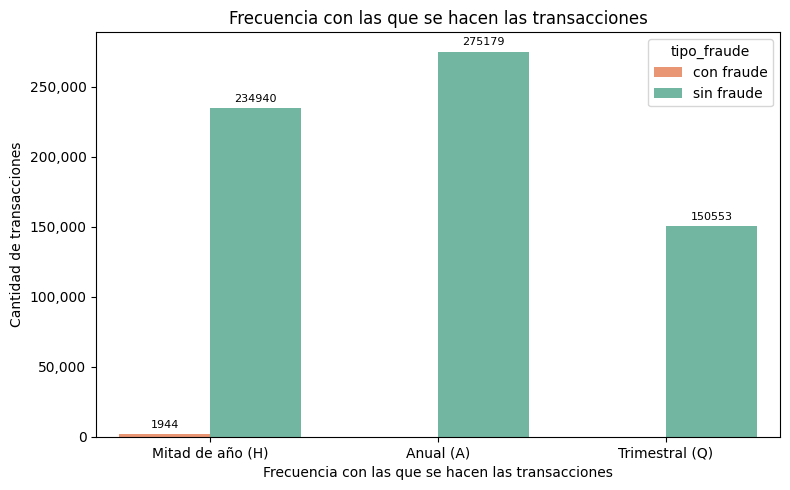

In [7]:
df_plot = tabla_frecuencia.copy()

df_plot['categoria'] = df_plot['categoria'].replace({
    'A': 'Anual (A)',
    'H': 'Mitad de año (H)',
    'Q': 'Trimestral (Q)'
})

df_plot['porcentaje'] = (
    df_plot.groupby('tipo_fraude')['n']
    .transform(lambda x: x / x.sum() * 100)
)

df_plot['label'] = df_plot.apply(
    lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)",
    axis=1
)

plt.figure(figsize=(8, 5))

palette1 = {
    'con fraude': '#fc8d62',
    'sin fraude': '#66c2a5'
}

ax = sns.barplot(
    x='categoria',
    y='n',
    hue='tipo_fraude',
    data=df_plot,
    palette=palette1,
    dodge=True
)

for container in ax.containers:
    fraude = container.get_label()
    porcentajes = df_plot.loc[df_plot['tipo_fraude'] == fraude, 'porcentaje'].values
    labels = [f"{int(v):,} ({p:.1f}%)"
              for v, p in zip(container.datavalues, porcentajes)]
    ax.bar_label(container, labels=labels, padding=3, fontsize=8)

plt.title('Frecuencia con las que se hacen las transacciones')
plt.xlabel('Frecuencia con las que se hacen las transacciones')
plt.ylabel('Cantidad de transacciones')

plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.tight_layout()
plt.show()

El gráfico muestra que la gran mayoría de las transacciones corresponden a la clase sin fraude, distribuyéndose principalmente en las categorías A (41.7%) y H (35.6%), mientras que Q representa una proporción menor. En contraste, los casos de fraude son extremadamente pocos y se concentran completamente en una sola categoría de frecuencia (H), lo que evidencia el fuerte desbalance de la variable respuesta.  

**Prueba de independencia**

In [8]:
tabla_frecuencia_chi = pd.crosstab(datos2['frecuencia'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_frecuencia_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 3504.0706
p-valor:        0.0000e+00
Grados de libertad: 2
Resultado: Rechaza H0 (dependientes)


Se rechaza H₀: hay evidencia suficiente para afirmar que la variable frecuencia y tipo_fraude no son independientes; es decir, existe asociación estadísticamente significativa entre la frecuencia con la que se realiza determinado pago y el tipo de fraude.

### Variable  pais_origen

In [9]:
tabla_COUNTRY = (
    datos2.groupby('tipo_fraude')['pais_origen']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'pais_origen': 'categoria'})
    .assign(variable='pais_origen')
)
tabla_COUNTRY['porcentaje'] = tabla_COUNTRY.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_COUNTRY = tabla_COUNTRY[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

from IPython.display import display, HTML

display(HTML(
    '<div style="height:400px; overflow-y:auto; border:1px solid #ccc;">'
    + tabla_COUNTRY.to_html(index=False) +
    '</div>'
))

tipo_fraude,variable,categoria,n,porcentaje
sin fraude,pais_origen,RO,28746,4.35
sin fraude,pais_origen,HU,28724,4.35
sin fraude,pais_origen,PL,28203,4.27
sin fraude,pais_origen,CZ,28063,4.25
sin fraude,pais_origen,NL,27204,4.12
sin fraude,pais_origen,PT,25600,3.87
sin fraude,pais_origen,LT,25520,3.86
sin fraude,pais_origen,DE,25149,3.81
sin fraude,pais_origen,FI,25092,3.80
sin fraude,pais_origen,LU,25086,3.80


La distribución del país de origen según la respuesta de si hubo fraude o no muestra diferencias relevantes en los patrones observados. En los casos donde se registró mayor proporción de fraude, el 5.86% corresponde a transacciones al area europea (U2), el 5.76% a estados miembros e instituciones de la Unión Europea (B0) y el 3.8% a España (ES). En contraste, en el grupo sin fraude, la mayor proporción (4.35%) corresponde al país de Romania(RO), mientras que el 4.34% a Hungria (HU) y el 4.26% a Polonia (PL) presentan valores ligeramente inferiores.
Esta diferencia sugiere las zonas donde es más propenso a que las transacciones realizadas sean fraude son: en el pais de España y en las zonas del area Europea y Union Europea, mientras que las transacciones de países como RO, HU y PL tienden a concentrarse en operaciones sin fraude, lo que podría ser relevante para estrategias de segmentación o análisis de comportamiento.

**Gráfico de barras multiple**

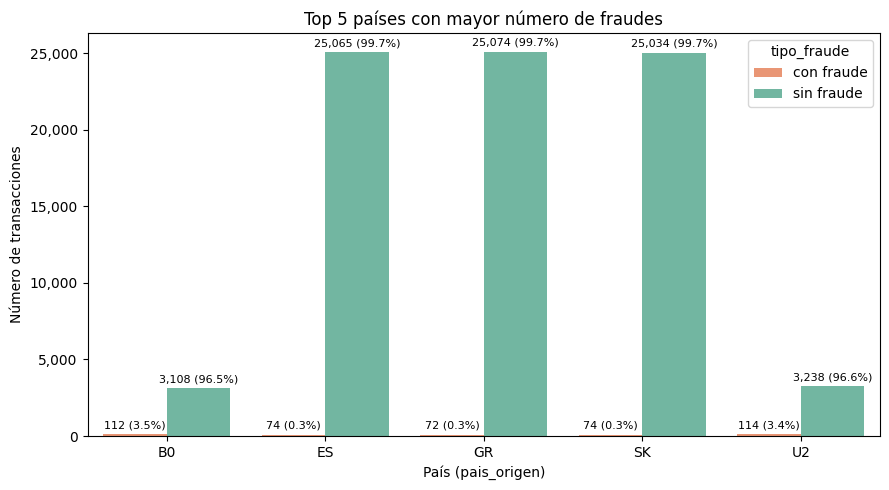

In [10]:
# Top 5 países con mayor número de fraudes
top5_paises = (
    datos2[datos2['tipo_fraude'] == 'con fraude']['pais_origen']
    .value_counts()
    .head(5)
    .index
)
df_plot = (
    datos2[datos2['pais_origen'].isin(top5_paises)]
    .groupby(['pais_origen', 'tipo_fraude'])
    .size()
    .reset_index(name='n')
)

df_plot['porcentaje'] = df_plot.groupby('pais_origen')['n'].transform(lambda x: x / x.sum() * 100)

df_plot['label'] = df_plot.apply(lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)", axis=1)
plt.figure(figsize=(9, 5))
ax = sns.barplot(x='pais_origen', y='n', hue='tipo_fraude', data=df_plot,
                 palette=palette1, dodge=True)
for container, (_, group) in zip(ax.containers, df_plot.groupby('tipo_fraude')):
    ax.bar_label(container, labels=group['label'], padding=3, fontsize=8)
plt.title('Top 5 países con mayor número de fraudes')
plt.xlabel('País (pais_origen)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico muestra que, aunque estos cinco países concentran el mayor número absoluto de fraudes, la proporción de transacciones fraudulentas dentro de cada país sigue siendo muy baja en comparación con las no fraudulentas. En todos los casos, más del 96% de las transacciones corresponden a la categoría sin fraude, mientras que los fraudes representan entre aproximadamente 0.3% y 3.5% del total por país. Por tanto, esto sigue demostrando el fuerte desvalance de la variable de respuesta. 

**Prueba de independencia**

In [11]:
tabla_chi = pd.crosstab(datos2['pais_origen'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 2288.8730
p-valor:        0.0000e+00
Grados de libertad: 28
Resultado: Rechaza H0 (dependientes)


Se rechaza HO: no hay evidencia suficiente para afirmar que la variable pais_origen y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre el país de origen y el tipo de fraude. 

### Variable pais_destino

In [12]:
# Tabla de distribución de pais_destino según tipo_fraude
tabla_ORGANIZATION = (
    datos2.groupby('tipo_fraude')['pais_destino']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'pais_destino': 'categoria'})
    .assign(variable='pais_destino')
)
tabla_ORGANIZATION['porcentaje'] = tabla_ORGANIZATION.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_ORGANIZATION = tabla_ORGANIZATION[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

display(HTML(
    '<div style="height:400px; overflow-y:auto; border:1px solid #ccc;">'
    + tabla_ORGANIZATION.to_html(index=False) +
    '</div>'
))

tipo_fraude,variable,categoria,n,porcentaje
sin fraude,pais_destino,W0,86789,13.14
sin fraude,pais_destino,W1,21755,3.29
sin fraude,pais_destino,W2,21507,3.26
sin fraude,pais_destino,G1,17392,2.63
sin fraude,pais_destino,SE,16057,2.43
sin fraude,pais_destino,DK,15769,2.39
sin fraude,pais_destino,BG,15488,2.34
sin fraude,pais_destino,GR,15440,2.34
sin fraude,pais_destino,SK,15437,2.34
sin fraude,pais_destino,SI,15437,2.34


La distribución de pais_destino según tipo_fraude muestra que las transacciones no fraudulentas se encuentran ampliamente distribuidas entre diversas áreas geográficas, destacándose entidades areas de referencia del mundo (W0) como la categoría con mayor participación (13.13%), seguida por el resto del mundo (W1) y hogares del mundo (W2), mientras que el resto de áreas presentan proporciones relativamente homogéneas alrededor del 2–3%.  
En contraste, los casos de fraude se concentran totalmente en la categoría W0, representando el 100% de los registros fraudulentos observados. Esta estructura evidencia una fuerte concentración geográfica del fraude frente a una distribución más diversificada de las transacciones legítimas, lo que sugiere que el riesgo no es uniforme entre áreas y que esta variable podría aportar capacidad explicativa en un modelo de clasificación. 

**Gráfico de cajas multiple**

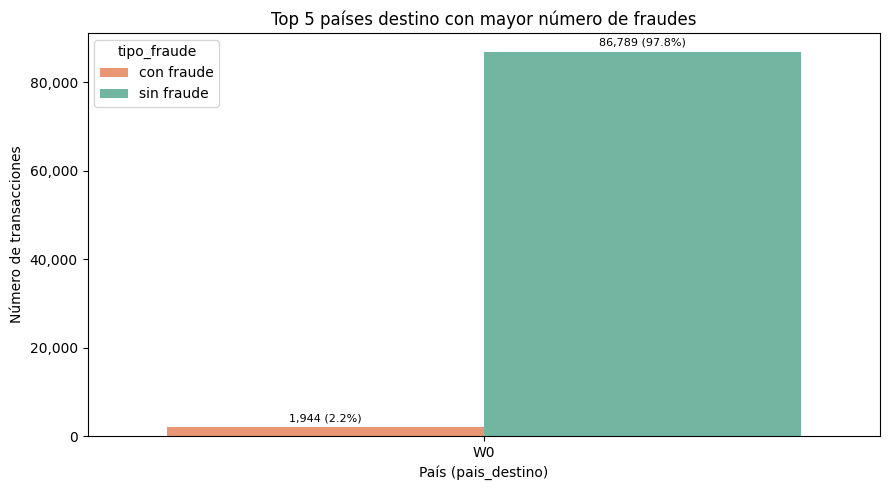

In [13]:
# Top 5 destinos con mayor número de fraudes
top5_dest = (
    datos2[datos2['tipo_fraude'] == 'con fraude']['pais_destino']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['pais_destino'].isin(top5_dest)]
    .groupby(['pais_destino', 'tipo_fraude'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('pais_destino')['n'].transform(lambda x: x / x.sum() * 100)
df_plot['label'] = df_plot.apply(lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)", axis=1)
plt.figure(figsize=(9, 5))
sns.barplot(x='pais_destino', y='n', hue='tipo_fraude', data=df_plot,
            palette=palette1, dodge=True)

ax = plt.gca()
for container, (_, group) in zip(ax.containers, df_plot.groupby('tipo_fraude')):
    ax.bar_label(container, labels=group['label'], padding=3, fontsize=8)


plt.title('Top 5 países destino con mayor número de fraudes')
plt.xlabel('País (pais_destino)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico evidencia que el área W0 (Mundo, todas las entidades, incluido el área de referencia, incluido IO) concentra la totalidad de los fraudes observados (1,944 casos), aunque estos representan solo el 2.2% del total de transacciones en esa región, frente al 97.8% correspondiente a operaciones no fraudulentas. Esto indica que, si bien el fraude está focalizado geográficamente en W0, su ocurrencia sigue siendo baja en términos proporcionales, confirmando el fuerte desbalance de la variable.

**Prueba de independencia**

In [14]:

tabla_chi = pd.crosstab(datos2['pais_destino'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 12609.8660
p-valor:        0.0000e+00
Grados de libertad: 50
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable pais_destino y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre la institución origen de la transacción y el tipo de fraude.

### Variable tipo_trx

In [15]:
# Tabla de distribución de tipo_trx según tipo_fraude
tabla_tipo_trx = (
    datos2.groupby('tipo_fraude')['tipo_trx']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'tipo_trx': 'categoria'})
    .assign(variable='tipo_trx')
)
tabla_tipo_trx['porcentaje'] = tabla_tipo_trx.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_tipo_trx = tabla_tipo_trx[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

display(HTML(
    '<div style="height:400px; overflow-y:auto; border:1px solid #ccc;">'
    + tabla_tipo_trx.to_html(index=False) +
    '</div>'
))

tipo_fraude,variable,categoria,n,porcentaje
sin fraude,tipo_trx,DD,96303,14.58
sin fraude,tipo_trx,CT0,96293,14.58
sin fraude,tipo_trx,EMP0,92400,13.99
sin fraude,tipo_trx,CHQ,92171,13.95
sin fraude,tipo_trx,CP0,59031,8.93
sin fraude,tipo_trx,SER,56995,8.63
sin fraude,tipo_trx,MREM,52242,7.91
sin fraude,tipo_trx,TOTL,48119,7.28
sin fraude,tipo_trx,TOTL1,44336,6.71
sin fraude,tipo_trx,CW1,18708,2.83


La distribución del tipo de transacción según la respuesta de si hubo fraude o no muestra diferencias relevantes en los patrones observados. En los tres casos donde hubo mayor fraude, el 37.75% corresponde a transacciones de pagos con tarjeta(CPO), el 19.13% al tipo de débitos directos (DD) y el 19.13% a pagos con dinero electrónico (EMPO), que fueron las de mayor porcentaje frente a los otros tipos.  

En contraste, en el grupo donde no hubo fraude, la mayoría (14.57%) fueron transacciones del tipo DD (débitos directos). Asimismo, la proporción de transacciones de tipo transferencias de crédito (CTO) fue del 14.57% y a pagos con dinero electrónico(EMPO) fue del 13.98%, que es ligeramente menor, pero se mantiene en un rango similar de porcentajes.  

Esta diferencia sugiere que las transacciones de tipo CPO, DD y EMPO son más propensas a presentar fraude. Sin embargo, dos de estas categorías (DD y EMPO) también estuvieron entre las tres con mayor proporción de transacciones sin fraude. La única que se diferencia claramente es el tipo de transacción de pagos con tarjeta (CPO), que resulta ser la más propensa a presentar fraude según el análisis, en comparación con otras que también registraron fraude.  

**Gráfico de barras múltiple**

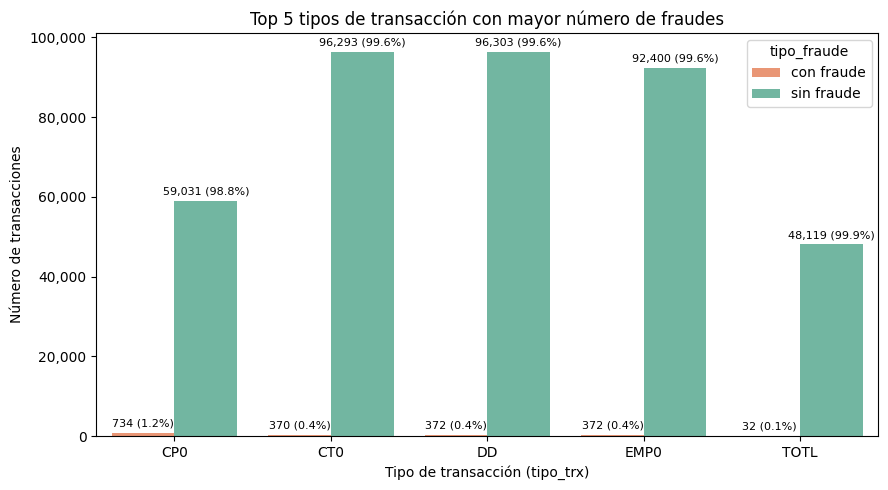

In [16]:
# Top 5 tipos de transacción con mayor número de fraudes
top5_trx = (
    datos2[datos2['tipo_fraude'] == 'con fraude']['tipo_trx']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['tipo_trx'].isin(top5_trx)]
    .groupby(['tipo_trx', 'tipo_fraude'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('tipo_trx')['n'].transform(lambda x: x / x.sum() * 100)
df_plot['label'] = df_plot.apply(lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)", axis=1)
plt.figure(figsize=(9, 5))
sns.barplot(x='tipo_trx', y='n', hue='tipo_fraude', data=df_plot,
            palette=palette1, dodge=True)

ax = plt.gca()
for container, (_, group) in zip(ax.containers, df_plot.groupby('tipo_fraude')):
    ax.bar_label(container, labels=group['label'], padding=3, fontsize=8)


plt.title('Top 5 tipos de transacción con mayor número de fraudes')
plt.xlabel('Tipo de transacción (tipo_trx)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

El gráfico se muestran los tipos de transferencia con pagos con tarjeta (CPO), Transferencias de crédito (CTO), débitos directos (DD), Pagos con dinero electrónico (EMPO) y Transacciones de pago totales (TOTL); aunque estos 5 tipos de transferencia concentran el mayor número absoluto de fraudes, la proporción de transacciones fraudulentas dentro de cada tipo sigue siendo muy baja en comparación con las no fraudulentas. En todos los casos, más del 98% de las transacciones corresponden a la categoría sin fraude, mientras que los fraudes representan entre aproximadamente 0.1% y 1.2% del total por cada tipo de transacción. Por tanto, las transacciones de pagos con tarjeta son las más propensas a que sean fraude con respecto a otros medios de pago.  

**Prueba de independencia**

In [17]:
tabla_chi = pd.crosstab(datos2['tipo_trx'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 2644.9980
p-valor:        0.0000e+00
Grados de libertad: 13
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable tipo_trx y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre la clasificación de la transacción y el tipo de fraude.  

### Variable tipo_psp

In [18]:

tabla_tipo_psp = (
    datos2.groupby('tipo_fraude')['tipo_psp']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'tipo_psp': 'categoria'})
    .assign(variable='tipo_psp')
)
tabla_tipo_psp['porcentaje'] = tabla_tipo_psp.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_tipo_psp = tabla_tipo_psp[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

tabla_tipo_psp

,tipo_fraude,variable,categoria,n,porcentaje
2,sin fraude,tipo_psp,1,386520,58.50
3,sin fraude,tipo_psp,2,270078,40.88
4,sin fraude,tipo_psp,_Z,4074,0.62
0,con fraude,tipo_psp,1,1204,61.93
1,con fraude,tipo_psp,2,740,38.07


La distribución de tipo_psp según la respuesta si hubo fraude o no, muestra diferencias relevantes en los patrones de respuesta. Entre las transacciones donde hubo fraude, el 61.93% corresponden a transacciones con rol tipo 1(PSP del pagador) y el 38.06% del tipo 2(PSP del beneficiario). En contraste, en el grupo donde no hubo fraude, la mayoría 58.5% fueron transacciones del rol tipo 1, mientras que el 40.87% al rol tipo 2 y 0.61% no aplica (_Z). Esta diferencia sugiere que las transacciones del rol tipo 1 son más propensas a que sean fraude, En general, las transacciones del tipo 1 son las que más se usan y son las que tienen mayor porcentaje de fraude respecto a las de tipo 2.

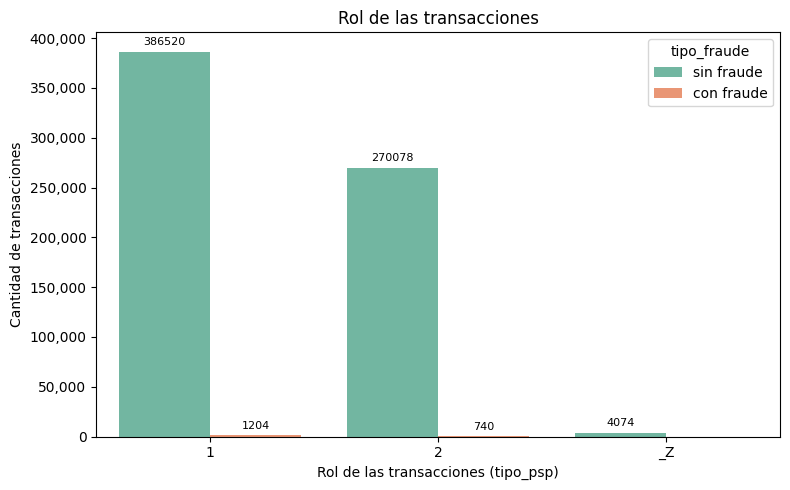

In [19]:

df_plot = tabla_tipo_psp.copy()

df_plot['label'] = df_plot.apply(
    lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)",
    axis=1
)

plt.figure(figsize=(8, 5))

ax = sns.barplot(x='categoria',y='n',hue='tipo_fraude',data=df_plot,palette='Set2',dodge=True
)

for container in ax.containers:
    labels = [f"{int(v):,} ({p:.1f}%)"
              for v, p in zip(
                  container.datavalues,
                  df_plot.loc[
                      df_plot['tipo_fraude'] ==
                      container.get_label(),
                      'porcentaje'
                  ]
              )]
    ax.bar_label(container, labels=labels, padding=3, fontsize=8)

plt.title('Rol de las transacciones')
plt.xlabel('Rol de las transacciones (tipo_psp)')
plt.ylabel('Cantidad de transacciones')

plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{int(x):,}')
)
plt.tight_layout()
plt.show()

La mayoría de las transacciones se concentran en el rol 1 (Payer’s PSP) con 58,5%, seguido del rol 2 (Payee’s PSP) con 40,9%, mientras que la categoría _Z es marginal (0,6%). En los casos de fraude (F) se mantiene esta tendencia, predominando también el rol 1 (61,9%), lo que indica que tanto el volumen total como los eventos fraudulentos se concentran principalmente en el PSP del pagador.  

**Prueba de independencia**

In [20]:
# Prueba chi-cuadrado: tipo_psp vs tipo_fraude
tabla_chi = pd.crosstab(datos2['tipo_psp'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 19.6388
p-valor:        5.4386e-05
Grados de libertad: 2
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable tipo_psp y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre la clasificación de la entidad procesa la transacción y el tipo de fraude.  

### Variable unidad

In [21]:
# Tabla de distribución de unidad según tipo_fraude
tabla_UNIT = (
    datos2.groupby('tipo_fraude')['unidad']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'unidad': 'categoria'})
    .assign(variable='unidad')
)
tabla_UNIT['porcentaje'] = tabla_UNIT.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_UNIT = tabla_UNIT[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']].sort_values('n', ascending=False)

display(HTML(
    '<div style="height:400px; overflow-y:auto; border:1px solid #ccc;">'
    + tabla_UNIT.to_html(index=False) +
    '</div>'
))

tipo_fraude,variable,categoria,n,porcentaje
sin fraude,unidad,PN,295384,44.71
sin fraude,unidad,EUR,257589,38.99
sin fraude,unidad,XDF,60941,9.22
sin fraude,unidad,PN_R_POP,7724,1.17
sin fraude,unidad,EUR_R_POP,7688,1.16
sin fraude,unidad,EUR_R_TT,7555,1.14
sin fraude,unidad,PN_R_TT,7523,1.14
sin fraude,unidad,EUR_R_PNT,7061,1.07
sin fraude,unidad,EUR_R_B1GQ,4487,0.68
sin fraude,unidad,XDF_R_TT,1560,0.24


La distribución de la unidad o divisa involucrada en las transacciones según la respuesta de si hubo fraude o no muestra diferencias relevantes en los patrones observados. En los tres casos donde hubo mayor fraude, el 49.58% corresponde a transacciones con divisa o unidad PN (número puro), el 41.25% a EUR (euro) y el 8.33% a XDF (moneda nacional), que fueron las de mayor porcentaje frente a los otros tipos.  
En contraste, en el grupo donde no hubo fraude, la mayoría (44.7%) fueron transacciones con divisa o unidad EUR. Asimismo, la proporción de transacciones con moneda nacional fue del38.98% y número puro per cápita (PN_R_POP) con un 13.98%, que es ligeramente menor.
Esta diferencia sugiere que las transacciones realizadas con divisa o unidad PN, EUR y XDF son más propensas a presentar fraude. Sin embargo, dos de estas categorías (EUR y XDF) también estuvieron entre las tres con mayor proporción de transacciones sin fraude. La única que se diferencia claramente es el tipo de transacción donde se utilizó PN (número puro), que resulta ser la más propensa a presentar fraude según el análisis, en comparación con otras que también registraron fraude.

**Gráfico de barras multiple**

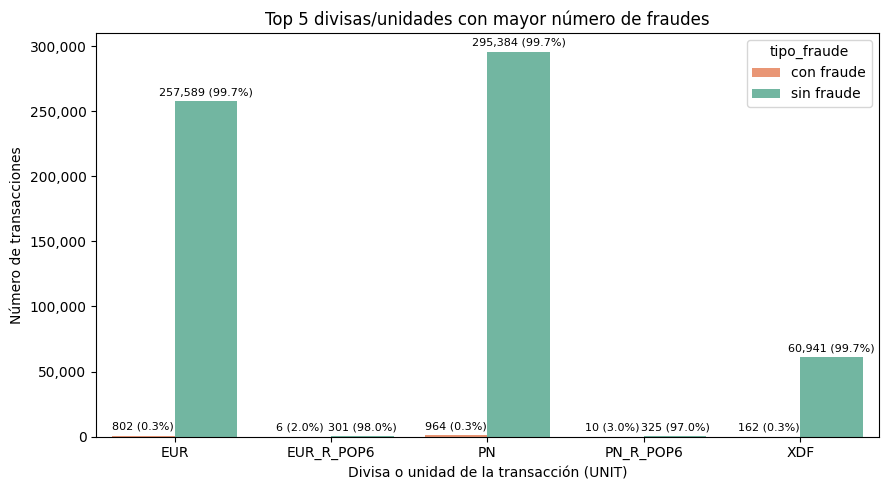

In [22]:
# Top 5 unidades con mayor número de fraudes
top5_unit = (
    datos2[datos2['tipo_fraude'] == 'con fraude']['unidad']
    .value_counts()
    .head(5)
    .index
)

df_plot = (
    datos2[datos2['unidad'].isin(top5_unit)]
    .groupby(['unidad', 'tipo_fraude'])
    .size()
    .reset_index(name='n')
)
df_plot['porcentaje'] = df_plot.groupby('unidad')['n'].transform(lambda x: x / x.sum() * 100)
df_plot['label'] = df_plot.apply(lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)", axis=1)
plt.figure(figsize=(9, 5))
sns.barplot(x='unidad', y='n', hue='tipo_fraude', data=df_plot,
            palette=palette1, dodge=True)

ax = plt.gca()
for container, (_, group) in zip(ax.containers, df_plot.groupby('tipo_fraude')):
    ax.bar_label(container, labels=group['label'], padding=3, fontsize=8)
    
plt.title('Top 5 divisas/unidades con mayor número de fraudes')
plt.xlabel('Divisa o unidad de la transacción (UNIT)')
plt.ylabel('Número de transacciones')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

La mayoría de las transacciones se registran en la categoría sin fraude, con proporciones cercanas al 99.7% en todas las unidades, mientras que las transacciones con fraude representa apenas alrededor del 0.3%. Aunque número puro (PN), Euro (EUR) y moneda nacional (XDF) concentran los mayores volúmenes, la incidencia relativa del fraude se mantiene estable entre monedas, lo que sugiere que el fraude se explica más por el volumen total de operaciones que por la unidad de transacción.  

**Prueba de independencia**

In [23]:

tabla_chi = pd.crosstab(datos2['unidad'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)

print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 262.2064
p-valor:        8.5336e-48
Grados de libertad: 14
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable unidad y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre unidad o divisa involucrada en la transacción y el tipo de fraude.

### Variable anio (año)

In [24]:

tabla_anio = (
    datos2.groupby('tipo_fraude')['anio']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'anio': 'categoria'})
    .assign(variable='anio')
)
tabla_anio['porcentaje'] = tabla_anio.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_anio = tabla_anio[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_anio.head(10)

,tipo_fraude,variable,categoria,n,porcentaje
0,con fraude,anio,2023,564,29.01
1,con fraude,anio,2024,564,29.01
2,con fraude,anio,2022,534,27.47
3,con fraude,anio,2025,282,14.51
4,sin fraude,anio,2023,143295,21.69
5,sin fraude,anio,2024,140071,21.20
6,sin fraude,anio,2022,136295,20.63
7,sin fraude,anio,2025,64070,9.70
8,sin fraude,anio,2018,17948,2.72
9,sin fraude,anio,2019,17948,2.72


Para este analisis la variable anio (año) se excluye frente a tipo_fraude porque presenta baja frecuencia por categoría, haciendo que sea poco interpretable. Además, anio corresponde a un código estructural compuesto que integra múltiples atributos técnicos, por lo que no representa una característica explicativa independiente con significado analítico propio. Cabe aclarar que aparecen pocas filas porque solo se mostraron las 40 primeras. Asimismo, no se realizará la prueba de independencia para esta variable con la de respuesta porque no es necesario para nuestro análisis y por la forma de esta variable. Lo único que se puede extraer de esta tabla es que en el año 2022, 2023 y 2024 fueron los años donde más fraude hubo, en el contexto de esta nueva era tecnológica producto del covid 19.  

### tipo_monto

In [25]:

tabla_tipo_monto = (
    datos2.groupby('tipo_fraude')['tipo_monto']
    .value_counts()
    .reset_index(name='n')
    .rename(columns={'tipo_monto': 'categoria'})
    .assign(variable='tipo_monto')
)
tabla_tipo_monto['porcentaje'] = tabla_tipo_monto.groupby('tipo_fraude')['n'].transform(lambda x: (x / x.sum()) * 100).round(2)
tabla_tipo_monto = tabla_tipo_monto[['tipo_fraude', 'variable', 'categoria', 'n', 'porcentaje']]

tabla_tipo_monto.head(40)

,tipo_fraude,variable,categoria,n,porcentaje
0,con fraude,tipo_monto,A,1475,75.87
1,con fraude,tipo_monto,P,251,12.91
2,con fraude,tipo_monto,Q,176,9.05
3,con fraude,tipo_monto,M,42,2.16
4,sin fraude,tipo_monto,A,481305,72.85
5,sin fraude,tipo_monto,Q,93425,14.14
6,sin fraude,tipo_monto,M,48955,7.41
7,sin fraude,tipo_monto,P,35065,5.31
8,sin fraude,tipo_monto,L,1277,0.19
9,sin fraude,tipo_monto,E,645,0.10


Para este análisis, en la variable tipo_monto no se excluirán las categorías L (valor faltante; los datos existen pero no fueron recopilados), M (valor faltante; los datos no pueden existir) y Q (valor faltante; suprimido), porque, a pesar de que corresponden a valores faltantes, la variable de respuesta de la investigación es si hubo o no fraude. Por tanto, se busca identificar este aspecto antes que determinar de cuánto fue el fraude.  
En este caso, la distribución del estado de la observación según tipo_fraude muestra diferencias relevantes en los patrones observados. Entre las transacciones con fraude (F), la categoría A (valor normal) es claramente mayoritaria (75.87%), seguida por P (valor provisional) (12.91%) y Q (valor faltante; reprimido) (9.05%), mientras que M (valor faltante; los datos no pueden existir) presenta una participación reducida (2.16%).  
En contraste, en las transacciones sin fraude, aunque A también predomina (72.85%), se aprecia una mayor presencia relativa de Q (14.14%), M (7.41%) y P (5.30%), además de categorías marginales como E y L. Esta diferencia sugiere que los eventos de fraude tienden a concentrarse principalmente en el estado A, mientras que las operaciones legítimas presentan una distribución más diversificada, lo que podría ser relevante para el análisis de riesgo y la identificación de patrones de comportamiento.  

**Gráfico de barras multiple**

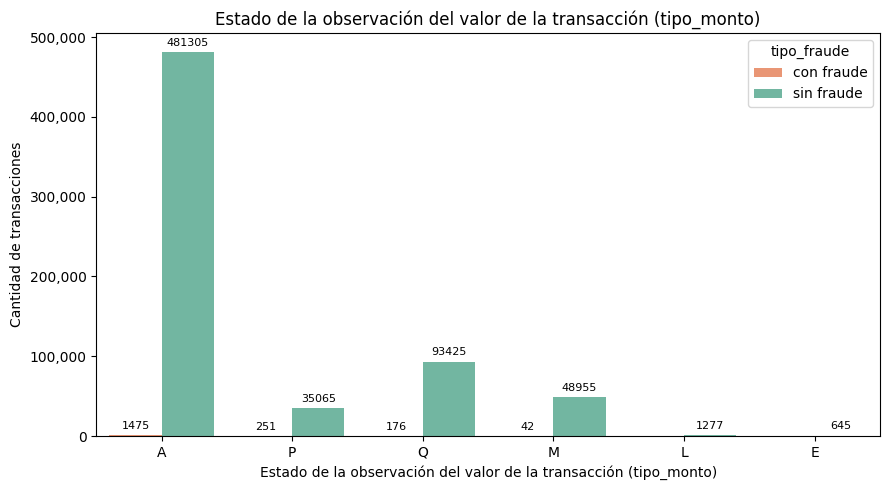

In [26]:

df_plot = tabla_tipo_monto.copy()
df_plot['label'] = df_plot.apply(
    lambda x: f"{int(x['n']):,} ({x['porcentaje']:.1f}%)",
    axis=1
)

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    x='categoria',
    y='n',
    hue='tipo_fraude',
    data=df_plot,
    palette=palette1,
    dodge=True
)

for container in ax.containers:
    fraude = container.get_label()
    porcentajes = df_plot.loc[df_plot['tipo_fraude'] == fraude, 'porcentaje'].values
    labels = [f"{int(v):,} ({p:.1f}%)"
              for v, p in zip(container.datavalues, porcentajes)]
    ax.bar_label(container, labels=labels, padding=3, fontsize=8)

plt.title('Estado de la observación del valor de la transacción (tipo_monto)')
plt.xlabel('Estado de la observación del valor de la transacción (tipo_monto)')
plt.ylabel('Cantidad de transacciones')

plt.gca().yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda x, _: f'{int(x):,}')
)

plt.tight_layout()
plt.show()

El gráfico de tipo_monto indica que la categoría A concentra la mayor parte de las transacciones (72.9%), seguida por Q (14.1%), M (7.4%) y P (5.3%), mientras que E y L tienen una participación marginal. En los casos de fraude (F) se mantiene la misma estructura general, con un claro predominio de A; sin embargo, se observa una participación relativamente mayor de P y Q en comparación con el total de transacciones. Esto sugiere que, aunque la distribución global está dominada por A, ciertas categorías como P y Q adquieren mayor relevancia relativa dentro de las operaciones fraudulentas.   

**Prueba de independencia**

In [27]:

tabla_chi = pd.crosstab(datos2['tipo_monto'], datos2['tipo_fraude'])
chi2, p, dof, expected = chi2_contingency(tabla_chi)


print(f"Estadístico X²: {chi2:.4f}")
print(f"p-valor:        {p:.4e}")
print(f"Grados de libertad: {dof}")
print(f"Resultado: {'Rechaza H0 (dependientes)' if p < 0.05 else 'No rechaza H0 (independientes)'}")

Estadístico X²: 326.1143
p-valor:        2.4212e-68
Grados de libertad: 5
Resultado: Rechaza H0 (dependientes)


Se rechaza H0: no hay evidencia suficiente para afirmar que la variable tipo_monto y tipo_fraude son independientes, es decir, existe asociación estadísticamente significativa entre el tipo de monto de la transacción y el tipo de fraude.

### Variable DESCRIPTION

Para este analisis la variable descripcionse excluye frente a tipo_fraude porque corresponde a un código estructural compuesto que integra múltiples atributos técnicos, en esta variable se describe la transacción y dice si hubo fraude, el tipo de transacción y si fue enviada, por lo cual, se tiene esta informacion de otras variables ya analizadas previamente. Asimismo, no se realizará la prueba de independencia para esta variable con la de respuesta porque no es necesario para nuestro análisis y por la forma de esta variable.  